In [1]:
import os
import glob
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
DATASET_ROOT = "./dataset"  
LABELS_DIR = os.path.join(DATASET_ROOT, "labels/train") 
YAML_PATH = os.path.join(DATASET_ROOT, "data.yaml")

In [3]:
print(f"Loading class names from {YAML_PATH}...")
try:
    with open(YAML_PATH, 'r') as f:
        data_cfg = yaml.safe_load(f)
        class_names = data_cfg.get('names', [])
        # Nếu names là dict {0: 'shirt'}, convert sang list
        if isinstance(class_names, dict):
            class_names = [class_names[i] for i in range(len(class_names))]
except Exception as e:
    print(f"Lỗi đọc data.yaml: {e}. Sẽ dùng ID thay thế.")
    class_names = []

Loading class names from ./dataset\data.yaml...


In [20]:
# tổng số ảnh
train_images = glob.glob(os.path.join(DATASET_ROOT, "images/train/*.jpg"))
num_images = len(train_images)
print(f"Tổng số ảnh trong tập train: {num_images}")

Tổng số ảnh trong tập train: 36498


In [8]:
txt_files = glob.glob(os.path.join(LABELS_DIR, "*.txt"))
print(f"Tìm thấy {len(txt_files)} file labels. Đang phân tích...")

stats = []
    
for txt_file in tqdm(txt_files):
    with open(txt_file, 'r') as f:
        lines = f.readlines()
        
    # Đếm số lượng object trong 1 ảnh
    obj_count_per_img = len(lines)
        
    for line in lines:
        parts = line.strip().split()
        if len(parts) < 5: continue
        
        # Format YOLO: class_id center_x center_y width height
        cls_id = int(parts[0])
        w = float(parts[3]) # Kích thước chuẩn hóa (0.0 -> 1.0)
        h = float(parts[4])
        
        # Diện tích tương đối (Box Area / Image Area)
        area = w * h 
        
        stats.append({
            'class_id': cls_id,
            'class_name': class_names[cls_id] if cls_id < len(class_names) else str(cls_id),
            'width': w,
            'height': h,
            'area': area,
            'obj_per_img': obj_count_per_img
        })

# Chuyển sang DataFrame để vẽ
df = pd.DataFrame(stats)

if df.empty:
    print("Không tìm thấy dữ liệu trong file .txt nào!")


Tìm thấy 36498 file labels. Đang phân tích...


100%|██████████| 36498/36498 [00:08<00:00, 4288.84it/s]


In [12]:
# xem class_name = cape
df_cape = df[df['class_name'] == 'cape']
print(df_cape.describe())

       class_id       width      height        area  obj_per_img
count     119.0  119.000000  119.000000  119.000000   119.000000
mean       12.0    0.508534    0.499343    0.282217     4.394958
std         0.0    0.201278    0.234880    0.232223     2.206379
min        12.0    0.125000    0.109375    0.033252     1.000000
25%        12.0    0.371428    0.318271    0.129808     3.000000
50%        12.0    0.477306    0.450195    0.203125     4.000000
75%        12.0    0.614705    0.666154    0.356728     6.000000
max        12.0    0.999023    0.999023    0.997521    12.000000



--- TỔNG QUAN ---
Tổng số Boxes: 134667
Số lượng Classes: 29


C:\Users\admin\AppData\Local\Temp\ipykernel_15776\928679757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


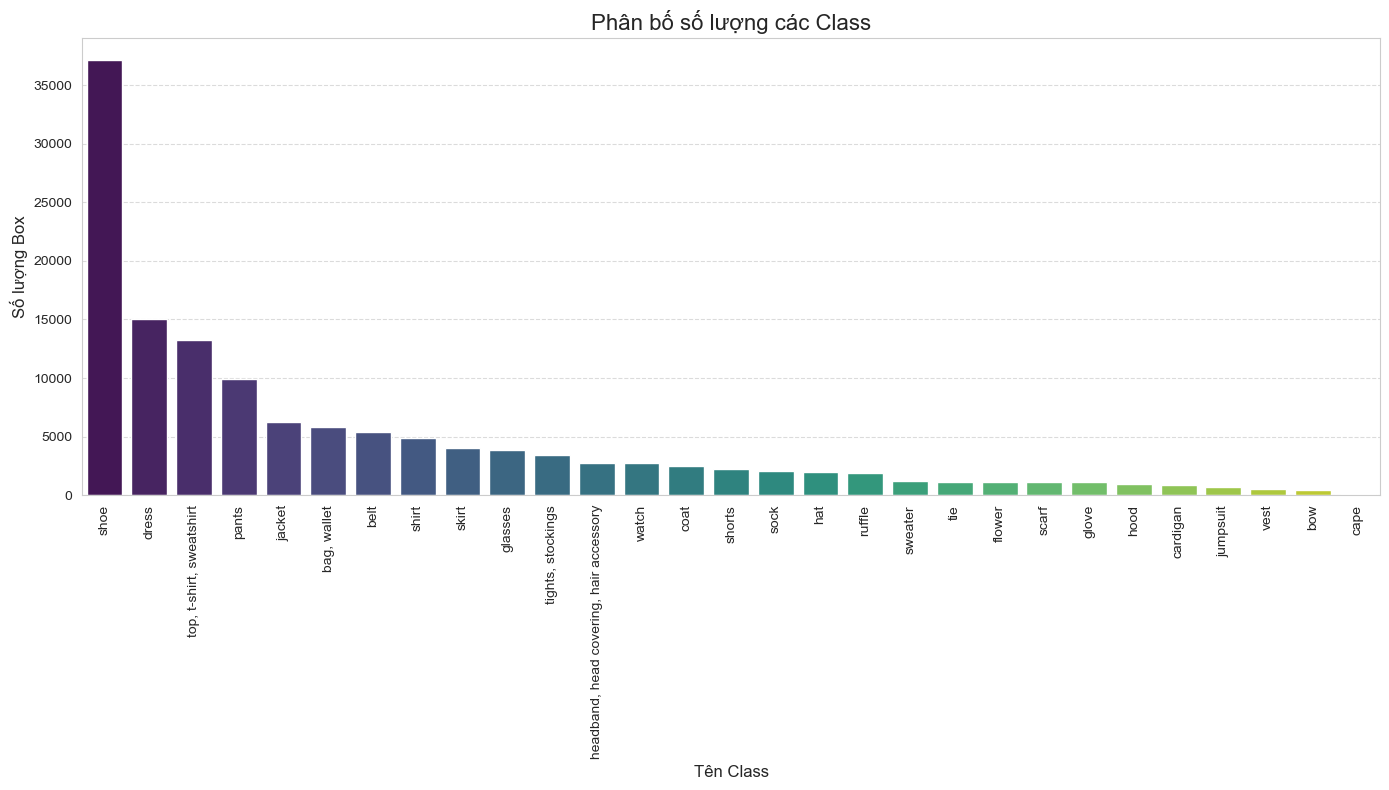

In [18]:

print(f"\n--- TỔNG QUAN ---")
print(f"Tổng số Boxes: {len(df)}")
print(f"Số lượng Classes: {df['class_id'].nunique()}")
plt.figure(figsize=(14, 8))
top_classes = df['class_name'].value_counts().nlargest(30).index
sns.countplot(
    data=df[df['class_name'].isin(top_classes)], 
    x='class_name', 
    order=top_classes, 
    palette="viridis"
)

plt.title("Phân bố số lượng các Class", fontsize=16)
plt.xlabel("Tên Class", fontsize=12)
plt.ylabel("Số lượng Box", fontsize=12)
plt.xticks(rotation=90) # Xoay tên class dọc xuống cho dễ đọc
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

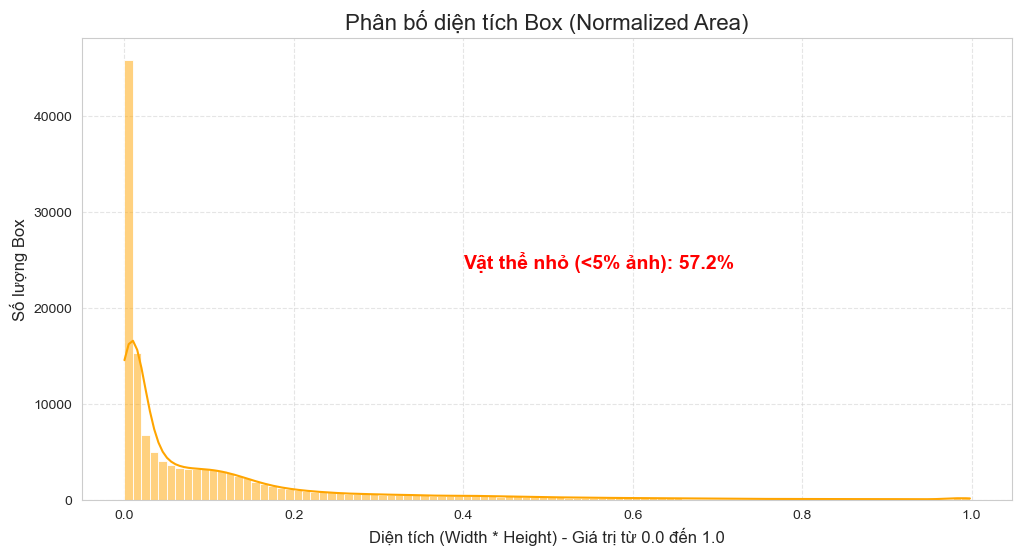

In [15]:
# Biểu đồ 2: Kích thước vật thể (Box Area Distribution)
# Giúp xem vật thể chủ yếu là to hay nhỏ
plt.figure(figsize=(12, 6))

# Vẽ biểu đồ phân phối diện tích (Area)
sns.histplot(data=df, x='area', bins=100, kde=True, color='orange')

plt.title("Phân bố diện tích Box (Normalized Area)", fontsize=16)
plt.xlabel("Diện tích (Width * Height) - Giá trị từ 0.0 đến 1.0", fontsize=12)
plt.ylabel("Số lượng Box", fontsize=12)

# Thêm chú thích quan trọng
small_obj_ratio = len(df[df['area'] < 0.05]) / len(df) * 100
plt.text(0.4, plt.ylim()[1]*0.5, 
         f"Vật thể nhỏ (<5% ảnh): {small_obj_ratio:.1f}%", 
         fontsize=14, color='red', fontweight='bold')

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



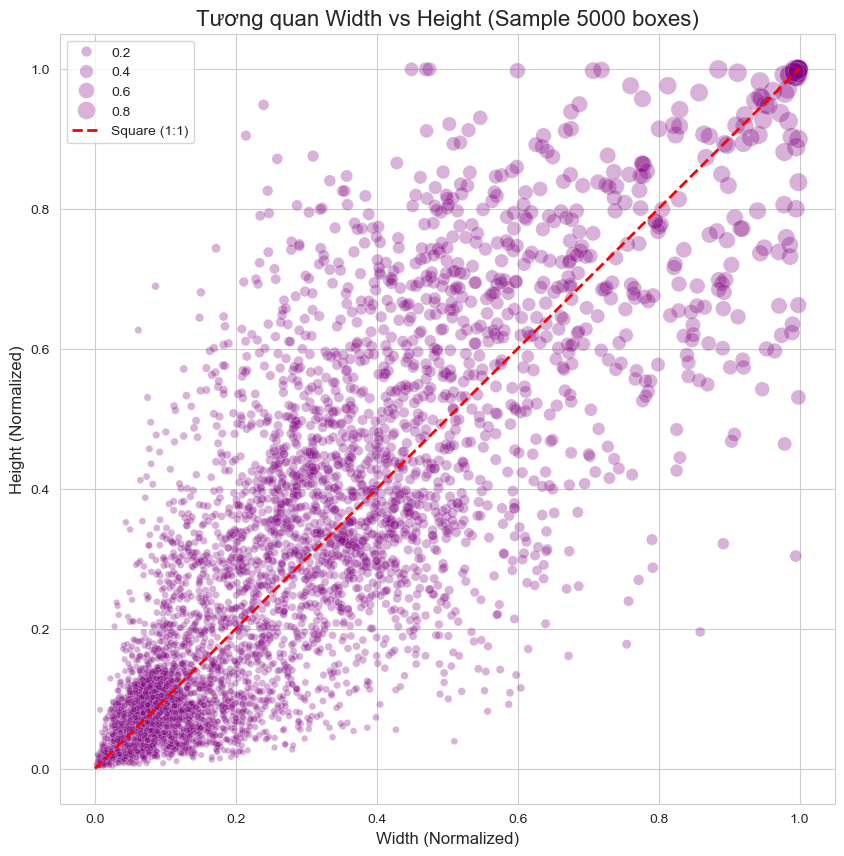

In [16]:
# Biểu đồ 3: Scatter Plot Width vs Height
# Xem tỉ lệ khung hình (dài/ngang)
plt.figure(figsize=(10, 10))

# Sample khoảng 5000 điểm để vẽ cho nhanh, vẽ hết sẽ rất lag
sample_df = df.sample(min(5000, len(df)))

sns.scatterplot(
    data=sample_df, 
    x='width', 
    y='height', 
    alpha=0.3, 
    size='area', 
    sizes=(20, 200),
    color='purple'
)

# Vẽ đường chéo thể hiện hình vuông (tỷ lệ 1:1)
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Square (1:1)')

plt.title("Tương quan Width vs Height (Sample 5000 boxes)", fontsize=16)
plt.xlabel("Width (Normalized)", fontsize=12)
plt.ylabel("Height (Normalized)", fontsize=12)
plt.legend()
plt.grid(True)

plt.show()

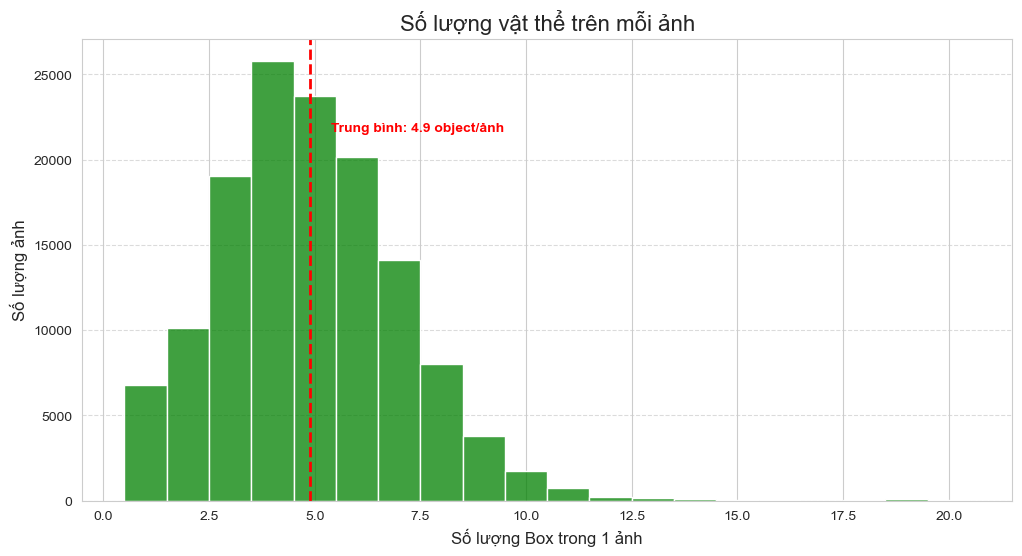

In [17]:
# Biểu đồ 4: Số lượng vật thể trong 1 ảnh
# Mỗi ảnh chứa bao nhiêu box?
# Vì obj_per_img lặp lại cho mỗi box, ta cần drop duplicates theo file (ở đây xấp xỉ bằng cách group)
# Cách đúng: đếm tần suất của cột obj_per_img rồi chia cho chính nó, 
# nhưng để nhanh ta plot histogram trực tiếp từ list ban đầu (hơi lệch nhẹ nhưng đủ xem xu hướng)
plt.figure(figsize=(12, 6))

# Đếm tần suất
sns.histplot(x=df['obj_per_img'], bins=range(0, 40), discrete=True, color='green')

plt.title("Số lượng vật thể trên mỗi ảnh", fontsize=16)
plt.xlabel("Số lượng Box trong 1 ảnh", fontsize=12)
plt.ylabel("Số lượng ảnh", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Hiển thị số trung bình
avg_obj = df['obj_per_img'].mean()
plt.axvline(avg_obj, color='red', linestyle='dashed', linewidth=2)
plt.text(avg_obj + 0.5, plt.ylim()[1]*0.8, f"Trung bình: {avg_obj:.1f} object/ảnh", color='red', fontweight='bold')

plt.show()